In [8]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt

In [20]:
data = loadmat('ex4data1.mat')

X = data['X'] # X has dimension of 5000 x 400
y = data['y'] #y has dimension of 5000 x 1

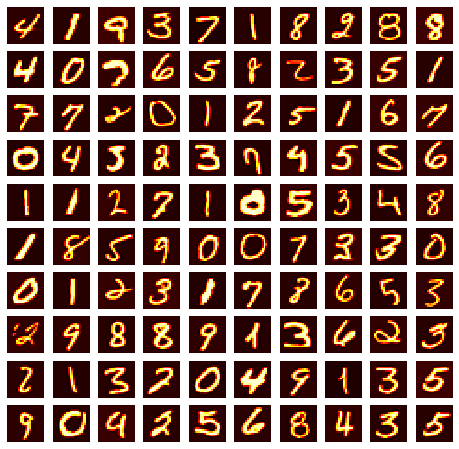

In [11]:
fig, axes = plt.subplots(10, 10, figsize = (8, 8))

for i in range(10):
    for j in range(10):
        axes[i, j].imshow(x[np.random.randint(x.shape[0])].reshape((20, 20), order = 'F'), cmap = 'hot')
        axes[i, j].axis('off')

In [34]:
weights = loadmat('ex4weights.mat')
theta1 = weights['Theta1']
theta2 = weights['Theta2']

# Set regularization parameter lambda
Lambda = 1

In [18]:
input_layer_size = 400
hidden_layer_size = 25
number_of_labels = 10

In [19]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [21]:
m = len(y)
ones = np.ones((m,1))
a1 = np.hstack((ones, X))
a2 = sigmoid(a1 @ theta1.T)
a2 = np.hstack((ones, a2))
h = sigmoid(a2 @ theta2.T)

In [24]:
y_d = pd.get_dummies(y.flatten())
J = np.zeros((number_of_labels, 1))

In [28]:
def nnCostFunction(h, y_d):
    temp1 = y_d * np.log(h)
    temp2 = (1-y_d) * np.log(1-h)
    temp3 = np.sum(temp1 + temp2)
    return np.sum(temp3 / (-m))

J = nnCostFunction(h, y_d)
print("Cost at parameters (non-regularized):",J)

Cost at parameters (non-regularized): 0.28762916516131876


In [35]:
def nnCostFunctionReg(theta1, theta2):
    sum1 = np.sum(np.sum(np.power(theta1[:,1:],2), axis = 1))
    sum2 = np.sum(np.sum(np.power(theta2[:,1:],2), axis = 1))
    return (sum1 + sum2) * Lambda / (2*m)

lr = nnCostFunctionReg(theta1, theta2)
reg_J = J + lr
print("Cost at parameters (Regularized):",reg_J)

Cost at parameters (Regularized): 0.38376985909092354


In [36]:
def sigmoidGrad(z):
    return np.multiply(sigmoid(z), 1-sigmoid(z))


def randInitializeWeights(L_in, L_out):
    epsilon = 0.12
    return np.random.rand(L_out, L_in+1) * 2 * epsilon - epsilon

In [43]:
initial_theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_theta2 = randInitializeWeights(hidden_layer_size, number_of_labels)
nn_initial_params = np.hstack((initial_theta1.ravel(order='F'), initial_theta2.ravel(order='F')))

delta1 = np.zeros(initial_theta1.shape)
delta2 = np.zeros(initial_theta2.shape)

for i in range(X.shape[0]):
    ones = np.ones(1)
    a1 = np.hstack((ones, X[i]))
    z2 = a1 @ initial_theta1.T
    a2 = np.hstack((ones, sigmoid(z2)))
    z3 = a2 @ initial_theta2.T
    a3 = sigmoid(z3)
    
    d3 = a3 - y_d.iloc[i,:][np.newaxis,:]
    
    z2 = np.hstack((ones, z2))
    
    d2 = np.multiply(initial_theta2.T @ d3.T, sigmoidGrad(z2).T[:,np.newaxis])
    delta1 = delta1 + d2[1:,:] @ a1[np.newaxis,:]
    delta2 = delta2 + d3.T @ a2[np.newaxis,:]
    
delta1 /= m
delta2 /= m


nn_params = np.hstack((theta1.ravel(order='F'), theta2.ravel(order='F')))

In [68]:
def nnCostFunc(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda):
    theta1 = np.reshape(nn_params[:hidden_layer_size*(input_layer_size+1)],
                        (hidden_layer_size, input_layer_size+1), 'F')
    theta2 = np.reshape(nn_params[hidden_layer_size*(input_layer_size+1):], (num_labels, hidden_layer_size+1), 'F')

    m = len(y)
    ones = np.ones((m,1))
    a1 = np.hstack((ones, X))
    a2 = sigmoid(a1 @ theta1.T)
    a2 = np.hstack((ones, a2))
    h = sigmoid(a2 @ theta2.T)
    
    y_d = pd.get_dummies(y.flatten())
    
    temp1 = np.multiply(y_d, np.log(h))
    temp2 = np.multiply(1-y_d, np.log(1-h))
    temp3 = np.sum(temp1 + temp2)
    
    sum1 = np.sum(np.sum(np.power(theta1[:,1:],2), axis = 1))
    sum2 = np.sum(np.sum(np.power(theta2[:,1:],2), axis = 1))
    
    return np.sum(temp3 / (-m)) + (sum1 + sum2) * lmbda / (2*m)

J = nnCostFunc(nn_initial_params, input_layer_size, hidden_layer_size, number_of_labels, X, y, Lambda)
print('Cost at initial theta:', J)

Cost at initial theta: 7.204043753250405


In [47]:
def nnGrad(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda):
    
    initial_theta1 = np.reshape(nn_params[:hidden_layer_size*(input_layer_size+1)],
                                (hidden_layer_size, input_layer_size+1), 'F')
    initial_theta2 = np.reshape(nn_params[hidden_layer_size*(input_layer_size+1):],
                                (num_labels, hidden_layer_size+1), 'F')
    
    y_d = pd.get_dummies(y.flatten())
    delta1 = np.zeros(initial_theta1.shape)
    delta2 = np.zeros(initial_theta2.shape)
    m = len(y)
    
    for i in range(X.shape[0]):
        ones = np.ones(1)
        a1 = np.hstack((ones, X[i]))
        z2 = a1 @ initial_theta1.T
        a2 = np.hstack((ones, sigmoid(z2)))
        z3 = a2 @ initial_theta2.T
        a3 = sigmoid(z3)

        d3 = a3 - y_d.iloc[i,:][np.newaxis,:]
        z2 = np.hstack((ones, z2))
        d2 = np.multiply(initial_theta2.T @ d3.T, sigmoidGrad(z2).T[:,np.newaxis])
        delta1 = delta1 + d2[1:,:] @ a1[np.newaxis,:]
        delta2 = delta2 + d3.T @ a2[np.newaxis,:]
        
    delta1 /= m
    delta2 /= m
    #print(delta1.shape, delta2.shape)
    delta1[:,1:] = delta1[:,1:] + initial_theta1[:,1:] * lmbda / m
    delta2[:,1:] = delta2[:,1:] + initial_theta2[:,1:] * lmbda / m
        
    return np.hstack((delta1.ravel(order='F'), delta2.ravel(order='F')))


nn_backprop_Params = nnGrad(nn_initial_params, input_layer_size, hidden_layer_size, number_of_labels, X, y, Lambda)

In [76]:
def checkGradient(nn_initial_params,nn_backprop_Params,input_layer_size, hidden_layer_size,
                  num_labels, myX, myy, mylambda=0.):
    myeps = 0.0001
    flattened = nn_initial_params
    flattenedDs = nn_backprop_Params
    n_elems = len(flattened) 
    #Pick ten random elements, compute numerical gradient, compare to respective D's
    for i in range(10):
        x = int(np.random.rand()*n_elems)
        epsvec = np.zeros((n_elems,1))
        epsvec[x] = myeps

        cost_high = nnCostFunc(flattened + epsvec.flatten(),input_layer_size, hidden_layer_size,
                               num_labels, myX, myy, mylambda)
        cost_low  = nnCostFunc(flattened - epsvec.flatten(),input_layer_size, hidden_layer_size,
                               num_labels, myX, myy, mylambda)
        mygrad = (cost_high - cost_low) / float(2*myeps)
        print("Element: {0}. Numerical Gradient = {1:.9f}. \tBackProp Gradient = {2:.9f}."
              .format(x, mygrad, flattenedDs[x]))
        
checkGradient(nn_initial_params,nn_backprop_Params,input_layer_size, hidden_layer_size,
              number_of_labels,X,y,Lambda)

Element: 9723. Numerical Gradient = -0.000017985. 	BackProp Gradient = -0.000017985.
Element: 1666. Numerical Gradient = -0.000169602. 	BackProp Gradient = -0.000169602.
Element: 1700. Numerical Gradient = -0.000501832. 	BackProp Gradient = -0.000501832.
Element: 3075. Numerical Gradient = -0.000003523. 	BackProp Gradient = -0.000003523.
Element: 5421. Numerical Gradient = 0.005332168. 	BackProp Gradient = 0.005332168.
Element: 4810. Numerical Gradient = 0.021060628. 	BackProp Gradient = 0.021060628.
Element: 4848. Numerical Gradient = -0.000709418. 	BackProp Gradient = -0.000709418.
Element: 8088. Numerical Gradient = 0.000110774. 	BackProp Gradient = 0.000110774.
Element: 9245. Numerical Gradient = 0.000034248. 	BackProp Gradient = 0.000034248.
Element: 472. Numerical Gradient = -0.000008670. 	BackProp Gradient = -0.000008670.


In [51]:
theta_opt = opt.fmin_cg(maxiter = 50, f = nnCostFunc, x0 = nn_initial_params, fprime = nnGrad,
                        args = (input_layer_size, hidden_layer_size, number_of_labels, X, y.flatten(), Lambda))

         Current function value: 0.425641
         Iterations: 50
         Function evaluations: 111
         Gradient evaluations: 111


In [61]:
theta1_opt = np.reshape(theta_opt[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, input_layer_size + 1), 'F')
theta2_opt = np.reshape(theta_opt[hidden_layer_size * (input_layer_size + 1):],
                        (number_of_labels, hidden_layer_size + 1), 'F')

J_opt = nnCostFunc(theta_opt, input_layer_size, hidden_layer_size, number_of_labels, X, y, Lambda)
print('Cost at optimized theta:', J_opt)

Cost at optimized theta: 0.4256408861544346


In [56]:
def predict(theta1, theta2, X, y):
    m = len(y)
    ones = np.ones((m,1))
    a1 = np.hstack((ones, X))
    a2 = sigmoid(a1 @ theta1.T)
    a2 = np.hstack((ones, a2))
    h = sigmoid(a2 @ theta2.T)
    return np.argmax(h, axis = 1) + 1

pred = predict(theta1_opt, theta2_opt, X, y)
acc = np.mean(pred == y.flatten()) * 100

print('Training Set Accuracy = '+ str(acc) +' %')

Training Set Accuracy = 96.94 %
